# ETH Price Prediction

Time searis of ETH Price

## 1. EDA

In [12]:
from pandas import read_csv
from pandas import datetime
from pandas import Series
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
import time
import numpy as np
#import plotly

# set random seed
np.random.seed(1337)

In [3]:
# date parser
import datetime as dt

def parser(timestamp):
    return dt.datetime.fromtimestamp(float(timestamp))

In [4]:
parser("1339521878.04")

datetime.datetime(2012, 6, 13, 1, 24, 38, 40000)

In [5]:
# load dataset
series = read_csv('data/etherprice.csv', header=0, names=['date', 'volume'], parse_dates=[0], 
                  index_col=0, squeeze=True, date_parser=parser)

In [6]:
# summarize first few rows
print(series.head())

date
2015-07-30 08:00:00    0.0
2015-07-31 08:00:00    0.0
2015-08-01 08:00:00    0.0
2015-08-02 08:00:00    0.0
2015-08-03 08:00:00    0.0
Name: volume, dtype: float64


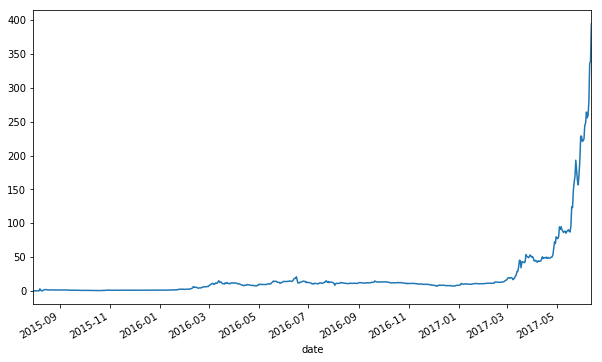

In [7]:
# line plot
pyplot.figure(figsize=(10,6))
series.plot()
pyplot.show()

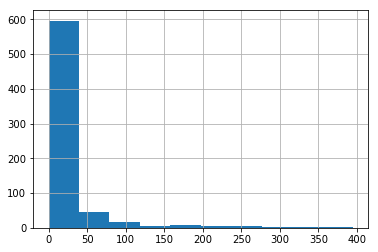

In [20]:
count, division = np.histogram(series)
series.hist(bins=division)
pyplot.show()

## 2. Check Stationarity

#### ACF and PACF

/home/frank/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


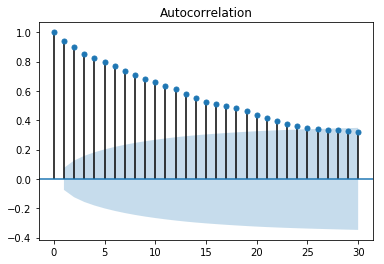

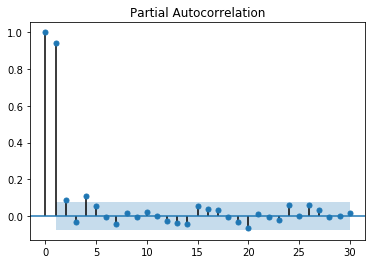

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(series, lags=30)
plot_pacf(series, lags=30)
pyplot.show()

#### ADF Test

In [22]:
from statsmodels.tsa.stattools import adfuller

X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 5.543679
p-value: 1.000000


We cannot reject the null hypothesis that the series is stationary

## 3. Data Transformation

Need to transform the non-stationary series into staionary one

In [8]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)


# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

Scale the data

In [9]:
from sklearn.preprocessing import MinMaxScaler

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
    
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X[0]] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

Frame the time series as a supervised learning problem

In [10]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [57]:
diff_values = difference(series.values, 1)
print diff_values.shape

(683,)


In [14]:
supervised = timeseries_to_supervised(diff_values, 1)
print(supervised.tail())

     0    0
0  0.0  0.0
1  0.0  0.0
2  0.0  0.0
3  0.0  0.0
4  0.0  0.0


In [15]:
# split data into train and test-sets
supervised_values = supervised.values
train, test = supervised_values[:680], supervised_values[680:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

Verify the shapes

In [16]:
print 'raw data:', supervised_values.shape
print 'train:', train_scaled.shape
print 'test:', test_scaled.shape

raw data: (683, 2)
train: (680, 2)
test: (3, 2)


## 4. LSTM Modeling

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import TensorBoard
from math import sqrt

Using TensorFlow backend.


### 4.1 Baseline Model

In [18]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    tensorboard = TensorBoard(log_dir='logs')
    
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, callbacks=[tensorboard])
        model.reset_states()
    return model

In [19]:
start_time = time.time()
lstm_model = fit_lstm(train_scaled, 1, 100, 4)
print "Done. Time used: ", (time.time() - start_time)

Done. Time used:  288.45270896


In [23]:
lstm_model.save('model-eth/eth.h5')

### 4.2 Model with Window Size of 7

Use data with lag (window size) of 7

In [58]:
supervised_lag7 = timeseries_to_supervised(diff_values, 7)
print(supervised_lag7.tail())

     0    0    0    0    0    0    0    0
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [59]:
# split data into train and test-sets
supervised_values = supervised_lag7.values
train_7, test_7 = supervised_values[:680], supervised_values[680:]

# transform the scale of the data
scaler_7, train_scaled_7, test_scaled_7 = scale(train_7, test_7)

In [60]:
print 'train:', train_scaled_7.shape
print 'test:', test_scaled_7.shape

train: (680, 8)
test: (3, 8)


Training

In [65]:
start_time = time.time()
lstm_model = fit_lstm(train_scaled_7, 1, 100, 4)
print "Done. Time used: ", (time.time() - start_time)

Done. Time used:  405.152107954


In [68]:
lstm_model.save('model-eth/eth_7.h5')

## 5. Testing

In [62]:
from keras.models import load_model
from sklearn.metrics import mean_squared_error


# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(X.shape[0], 1, X.shape[1])
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


# make prediction and plot the results
def evaluation(lstm_model, raw_values, scaled_data, expected_values, scaler, batch_size=1):
    # forecast the entire training dataset to build up state for forecasting
    train = scaled_data[:, 0:-1]
    train_reshaped = train.reshape(train.shape[0], 1, train.shape[1])
    lstm_model.predict(train_reshaped, batch_size=batch_size)

    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(scaled_data) - batch_size + 1):
        # make one-step forecast
        X, y = scaled_data[i:i+batch_size, 0:-1], scaled_data[i:i+batch_size, -1]
        yhat = forecast_lstm(lstm_model, batch_size, X)

        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(scaled_data)+1-i)

        # store forecast
        predictions.append(yhat)

    # report performance
    rmse = sqrt(mean_squared_error(expected_values, predictions))
    print('Test RMSE: %.3f' % rmse)

    # line plot of observed vs predicted
    pyplot.figure(figsize=(10,6))
    pyplot.plot(expected_values, label="expected")
    pyplot.plot(predictions, label="prediction")
    pyplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pyplot.show()

### 5.1 Baseline Model

Check the model against training data

In [77]:
lstm_model = load_model('model-eth/eth.h5')

Test RMSE: 7.230


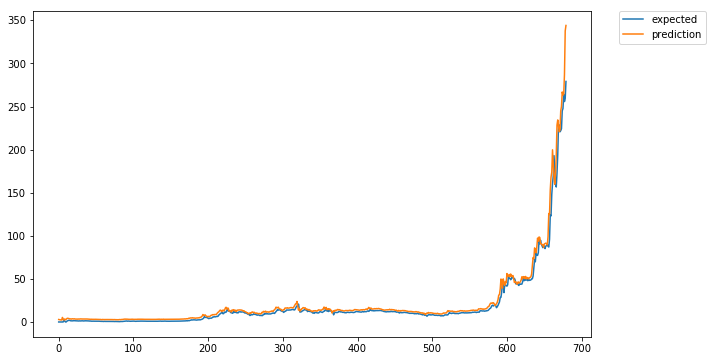

In [32]:
evaluation(lstm_model, series.values, train_scaled, series.values[1:681], scaler)

Evaluate against test data

Test RMSE: 62.467


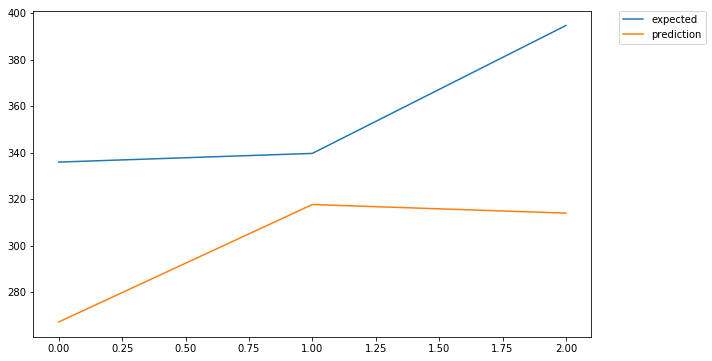

In [33]:
evaluation(lstm_model, series.values, test_scaled, series.values[681:], scaler)

### 5.2 Model with Window Size of 7

In [50]:
lstm_model = load_model('model-eth/eth_7.h5')

Check the model against training data

Test RMSE: 7.563


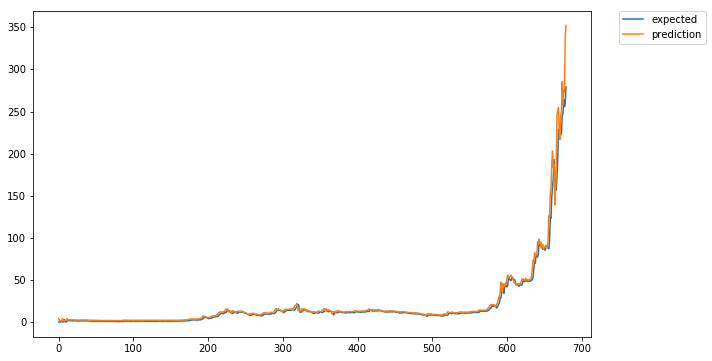

In [66]:
evaluation(lstm_model, series.values, train_scaled_7, series.values[1:681], scaler_7)

Evaluate against test data

Test RMSE: 26.986


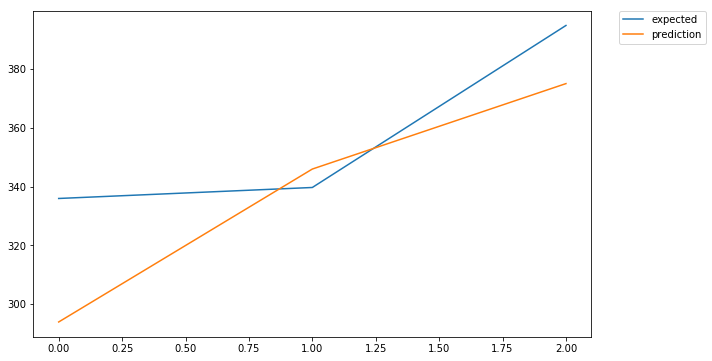

In [67]:
evaluation(lstm_model, series.values, test_scaled_7, series.values[681:], scaler_7)

We can see that with only 4 units and 100 epochs, the result is already quite ok.